# Dog Breed Detector 🐶

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
class_folder_paths = ['../input/70-dog-breedsimage-data-set/test/'+x for x in os.listdir('../input/70-dog-breedsimage-data-set/test/')]

In [3]:
for class_folder_path in class_folder_paths:
    print('{0}:'.format(class_folder_path), ' ', len(os.listdir(class_folder_path)))

../input/70-dog-breedsimage-data-set/test/Cocker:   10
../input/70-dog-breedsimage-data-set/test/American Spaniel:   10
../input/70-dog-breedsimage-data-set/test/Bichon Frise:   10
../input/70-dog-breedsimage-data-set/test/Beagle:   10
../input/70-dog-breedsimage-data-set/test/Pomeranian:   10
../input/70-dog-breedsimage-data-set/test/Bermaise:   10
../input/70-dog-breedsimage-data-set/test/Schnauzer:   10
../input/70-dog-breedsimage-data-set/test/Groenendael:   10
../input/70-dog-breedsimage-data-set/test/Komondor:   10
../input/70-dog-breedsimage-data-set/test/Afghan:   10
../input/70-dog-breedsimage-data-set/test/Bluetick:   10
../input/70-dog-breedsimage-data-set/test/Pekinese:   10
../input/70-dog-breedsimage-data-set/test/Chow:   10
../input/70-dog-breedsimage-data-set/test/Maltese:   10
../input/70-dog-breedsimage-data-set/test/Elk Hound:   10
../input/70-dog-breedsimage-data-set/test/Irish Wolfhound:   10
../input/70-dog-breedsimage-data-set/test/Shih-Tzu:   10
../input/70-dog-

In [4]:
TRAIN_DIR = '../input/70-dog-breedsimage-data-set/train/'
VAL_DIR = '../input/70-dog-breedsimage-data-set/valid/'
TEST_DIR = '../input/70-dog-breedsimage-data-set/test/'

In [5]:
train_dogs=os.listdir(TRAIN_DIR)

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

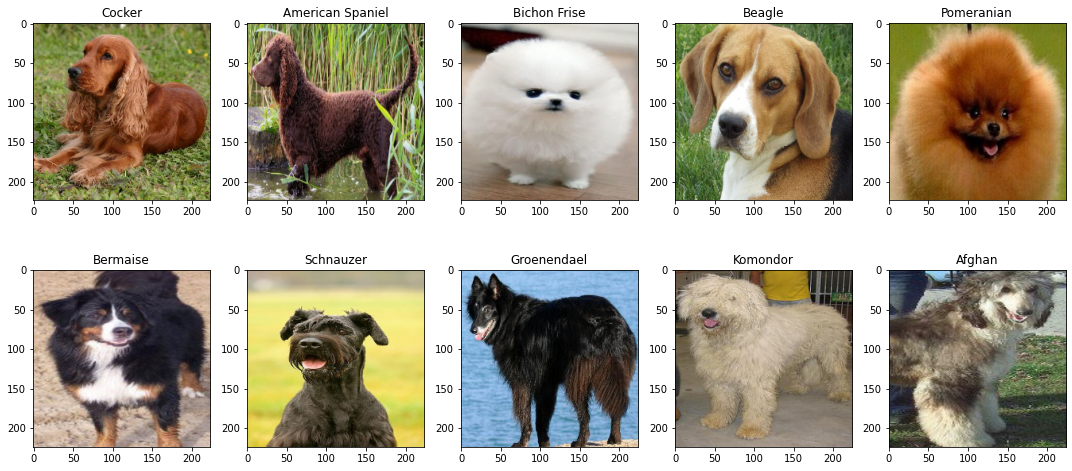

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))
for i, ax in enumerate(axes.flat):
    dir = TRAIN_DIR + "/" + train_dogs[i] + "/"
    ax.imshow(Image.open(dir + os.listdir(dir)[0]))
    ax.set_title(train_dogs[i])
plt.tight_layout()
plt.show()

## Data Preprocessing

In [8]:
train_data_gen = ImageDataGenerator(horizontal_flip = True,
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2)

train_generator = train_data_gen.flow_from_directory(TRAIN_DIR,
                                                     target_size = (224, 224),
                                                     color_mode = 'rgb',
                                                     batch_size = 32,
                                                     class_mode ='categorical',
                                                     shuffle = True)

val_data_gen = ImageDataGenerator()

val_generator = val_data_gen.flow_from_directory(VAL_DIR,
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   shuffle = False)
val_data_gen = ImageDataGenerator()

test_generator = val_data_gen.flow_from_directory(TEST_DIR,
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   shuffle = False)

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [9]:
labels = train_generator.class_indices
class_mapping = dict((v,k) for k,v in labels.items())
class_mapping

{0: 'Afghan',
 1: 'African Wild Dog',
 2: 'Airedale',
 3: 'American Hairless',
 4: 'American Spaniel',
 5: 'Basenji',
 6: 'Basset',
 7: 'Beagle',
 8: 'Bearded Collie',
 9: 'Bermaise',
 10: 'Bichon Frise',
 11: 'Blenheim',
 12: 'Bloodhound',
 13: 'Bluetick',
 14: 'Border Collie',
 15: 'Borzoi',
 16: 'Boston Terrier',
 17: 'Boxer',
 18: 'Bull Mastiff',
 19: 'Bull Terrier',
 20: 'Bulldog',
 21: 'Cairn',
 22: 'Chihuahua',
 23: 'Chinese Crested',
 24: 'Chow',
 25: 'Clumber',
 26: 'Cockapoo',
 27: 'Cocker',
 28: 'Collie',
 29: 'Corgi',
 30: 'Coyote',
 31: 'Dalmation',
 32: 'Dhole',
 33: 'Dingo',
 34: 'Doberman',
 35: 'Elk Hound',
 36: 'French Bulldog',
 37: 'German Sheperd',
 38: 'Golden Retriever',
 39: 'Great Dane',
 40: 'Great Perenees',
 41: 'Greyhound',
 42: 'Groenendael',
 43: 'Irish Spaniel',
 44: 'Irish Wolfhound',
 45: 'Japanese Spaniel',
 46: 'Komondor',
 47: 'Labradoodle',
 48: 'Labrador',
 49: 'Lhasa',
 50: 'Malinois',
 51: 'Maltese',
 52: 'Mex Hairless',
 53: 'Newfoundland',
 54

## Model Initialization (Resnet50V2) 

In [10]:
# Preprocessing layer
before_resnet = Sequential([
    Input((224, 224, 3)),
    Lambda(preprocess_input)
])

# Base ResNet50V2 model
resnet = ResNet50V2(input_shape=(224, 224, 3), include_top=False)

# Custom layers after ResNet50V2
after_resnet = Sequential([
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(70, activation='softmax')  # Assuming 70 dog breeds
])

# Complete model
model = Sequential([
    before_resnet,
    resnet,
    after_resnet
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94683136/94668760 [==============================] - 0s 0us/step


In [11]:
opt = Adam(learning_rate=0.00001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
model.build(((None, 224, 224, 3)))

before_resnet.summary()
resnet.summary()
after_resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112

## Training the Model

In [13]:
train_cb = ModelCheckpoint('./model/', save_best_only = True)

model.fit(train_generator, validation_data = val_generator, callbacks = [train_cb], epochs = 20)

Epoch 1/20
249/249 [==============================] - 147s 542ms/step - loss: 3.8440 - accuracy: 0.1236 - val_loss: 2.7437 - val_accuracy: 0.3743


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
249/249 [==============================] - 93s 374ms/step - loss: 2.4415 - accuracy: 0.4675 - val_loss: 1.2982 - val_accuracy: 0.7543


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/20
249/249 [==============================] - 93s 375ms/step - loss: 1.4710 - accuracy: 0.6918 - val_loss: 0.8018 - val_accuracy: 0.8600


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/20
249/249 [==============================] - 94s 378ms/step - loss: 0.9998 - accuracy: 0.7702 - val_loss: 0.6097 - val_accuracy: 0.8971


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/20
249/249 [==============================] - 94s 375ms/step - loss: 0.7632 - accuracy: 0.8130 - val_loss: 0.5260 - val_accuracy: 0.9129


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/20
249/249 [==============================] - 94s 378ms/step - loss: 0.6079 - accuracy: 0.8458 - val_loss: 0.4801 - val_accuracy: 0.9171


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/20
249/249 [==============================] - 94s 376ms/step - loss: 0.5401 - accuracy: 0.8604 - val_loss: 0.4670 - val_accuracy: 0.9143


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/20
249/249 [==============================] - 94s 378ms/step - loss: 0.4641 - accuracy: 0.8786 - val_loss: 0.4464 - val_accuracy: 0.9214


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/20
249/249 [==============================] - 94s 377ms/step - loss: 0.4162 - accuracy: 0.8898 - val_loss: 0.4285 - val_accuracy: 0.9271


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/20
249/249 [==============================] - 94s 376ms/step - loss: 0.3635 - accuracy: 0.9001 - val_loss: 0.4262 - val_accuracy: 0.9329


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/20
249/249 [==============================] - 96s 385ms/step - loss: 0.3228 - accuracy: 0.9130 - val_loss: 0.4218 - val_accuracy: 0.9371


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/20
249/249 [==============================] - 94s 379ms/step - loss: 0.3000 - accuracy: 0.9192 - val_loss: 0.4200 - val_accuracy: 0.9300


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/20
249/249 [==============================] - 94s 376ms/step - loss: 0.2722 - accuracy: 0.9265 - val_loss: 0.4154 - val_accuracy: 0.9357


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/20
249/249 [==============================] - 94s 375ms/step - loss: 0.2456 - accuracy: 0.9368 - val_loss: 0.4174 - val_accuracy: 0.9329
Epoch 15/20
249/249 [==============================] - 93s 374ms/step - loss: 0.2258 - accuracy: 0.9380 - val_loss: 0.4348 - val_accuracy: 0.9300
Epoch 16/20
249/249 [==============================] - 96s 386ms/step - loss: 0.1984 - accuracy: 0.9483 - val_loss: 0.4169 - val_accuracy: 0.9371
Epoch 17/20
249/249 [==============================] - 94s 376ms/step - loss: 0.1854 - accuracy: 0.9484 - val_loss: 0.4281 - val_accuracy: 0.9314
Epoch 18/20
249/249 [==============================] - 94s 377ms/step - loss: 0.1635 - accuracy: 0.9592 - val_loss: 0.4222 - val_accuracy: 0.9343
Epoch 19/20
249/249 [==============================] - 95s 382ms/step - loss: 0.1525 - accuracy: 0.9577 - val_loss: 0.4312 - val_accuracy: 0.9257
Epoch 20/20
249/249 [==============================] - 95s 381ms/step - loss: 0.1459 - accuracy: 0.9627 - val_loss: 0.4300 -

In [14]:
model.save('ResNet50V2_model.h5')

In [15]:
model.evaluate(test_generator)

22/22 [==============================] - 5s 247ms/step - loss: 0.1271 - accuracy: 0.9629


[0.12711550295352936, 0.9628571271896362]